In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

warnings.filterwarnings("ignore")

In [2]:
# create a function to import dataset
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    return df

In [3]:
# import dataset with wrangle function
maternity = wrangle("Dataset - Updated.csv")
maternity.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.0,60.0,9.0,100,18.0,1.0,1.0,0,1,80.0,High
1,22,110.0,70.0,7.1,98,20.4,0.0,0.0,0,0,74.0,Low
2,27,110.0,70.0,7.5,98,23.0,1.0,0.0,0,0,72.0,Low
3,20,100.0,70.0,7.2,98,21.2,0.0,0.0,0,0,74.0,Low
4,20,90.0,60.0,7.5,98,19.7,0.0,0.0,0,0,74.0,Low


In [4]:
maternity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     1205 non-null   int64  
 1   Systolic BP             1200 non-null   float64
 2   Diastolic               1201 non-null   float64
 3   BS                      1203 non-null   float64
 4   Body Temp               1205 non-null   int64  
 5   BMI                     1187 non-null   float64
 6   Previous Complications  1203 non-null   float64
 7   Preexisting Diabetes    1203 non-null   float64
 8   Gestational Diabetes    1205 non-null   int64  
 9   Mental Health           1205 non-null   int64  
 10  Heart Rate              1203 non-null   float64
 11  Risk Level              1187 non-null   object 
dtypes: float64(7), int64(4), object(1)
memory usage: 113.1+ KB


## <p align="center"> Definition of Features in dataset </p>
| Variable | Definition | Type | Unit/Value |
|:------:|:-------------------:|:-----------:|:--------------:|
| Age | Age of the patient | Numeric | Years |
| Systolic BP | Systolic blood pressure, indicating the force exerted on artery walls when the heart beats. Elevated signs can indicate hypertension | Numeric | mmHg |
| Diastolic | Diastolic blood pressure, measuring pressure between heartbeats. High values can be a sign of gestational hypertension or preeclampsia risk | Numeric | mmHg |
| BS | Blood sugar level, can be used to monitor gestational diabetes, that can affect fetal and maternal health | Numeric | mmol/L
| Body Temp | Patient's Body Temperature, can help identify infection or inflammation | Numeric | Fahrenheit |
| BMI | Body Mass Index, measures body fat based on height and weight. Higher values can be associated with gestational diabetes and hypertension | Numeric | kg/m2
| Previous Complications | Binary indicator (0 or 1) for complications in previous pregnancies | Binary | 0,1 |
| Preexisting Diabetes | Indicates whether the patient has a history of diabetes | Binary | 0,1 |
| Gestational Diabetes | Presence of Diabetes developed during pregnancy | Binary | 0,1 |
| Mental Health | Indicator of Mental Health Issues | Binary | 0,1|
| Heart Rate | Heart rate of patient, when elevated, may indicate stress or cardiovascular strain | Numeric | Beats per Minute (bpm)
| Risk Level | Categorized risk level (e.g., High, Low), assessing the overall health risk based on the patient's profile | Categorical | Low, High |

In [5]:
# check shape of dataset
maternity.shape

(1205, 12)

In [6]:
# check the statistics summary
maternity.describe()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
count,1205.000000,1200.000000,1201.000000,1203.000000,1205.000000,1187.000000,1203.000000,1203.000000,1205.000000,1205.00000,1203.000000
mean,27.731950,116.819167,77.166528,7.501064,98.395851,23.315080,0.175395,0.288446,0.117842,0.33444,75.817124
std,12.571074,18.715502,14.305148,3.049522,1.088363,3.875682,0.380463,0.453228,0.322555,0.47199,7.227338
min,10.000000,70.000000,40.000000,3.000000,97.000000,0.000000,0.000000,0.000000,0.000000,0.00000,58.000000
25%,21.000000,100.000000,65.000000,6.000000,98.000000,20.450000,0.000000,0.000000,0.000000,0.00000,70.000000
50%,25.000000,120.000000,80.000000,6.900000,98.000000,23.000000,0.000000,0.000000,0.000000,0.00000,76.000000
75%,32.000000,130.000000,90.000000,7.900000,98.000000,25.000000,0.000000,1.000000,0.000000,1.00000,80.000000
max,325.000000,200.000000,140.000000,19.000000,103.000000,37.000000,1.000000,1.000000,1.000000,1.00000,92.000000


* From the summary statistics, an anomaly can be seen in the age column where the highest age is 325 years.
This is obviously a data entry error. 
* I thought to imput it with 32, which is the 75th percentile, but then the correct age could have been 25 years, which is closer to the mean
* To ensure accuracy and transparency, I will drop the row
* BMI also has some invalid values, as the minimum is zero(0), which is not possible

In [7]:
# check out the anomaly in age column
maternity["Age"].unique()

array([ 22,  27,  20,  23,  26,  25,  19,  18,  24,  21,  44,  17,  28,
        40,  37,  29,  34,  35,  36,  32,  38,  48,  30,  39,  31,  33,
        41, 325,  42,  15,  50,  63,  55,  49,  16,  12,  60,  65,  43,
        13,  54,  10,  45])

In [8]:
maternity["BMI"].unique()

array([18. , 20.4, 23. , 21.2, 19.7, 24. , 17.6, 21.3, 22. , 30.2, 24.5,
       30. , 21. , 21.5,  nan, 18.6, 19. , 20. , 25.3, 23.8, 20.2, 23.7,
       24.2, 25. , 19.3, 18.8, 23.4, 22.8, 18.5, 30.1, 26.6, 23.2, 22.9,
       22.5, 19.4, 33. , 26. , 25.2, 25.7, 27. , 25.5, 18.9, 23.1, 24.4,
       17. , 30.3, 31. , 24.7, 24.8, 20.5, 32. , 26.7, 28. , 24.9, 25.9,
       27.2, 32.2, 29.9, 26.2, 31.4, 25.8, 32.4, 31.3, 27.5, 18.4, 18.2,
       25.4, 18.3, 31.6, 17.8, 29. , 26.5, 26.4, 27.4, 32.9, 29.6, 30.5,
       28.4, 35. , 29.7, 30.6, 29.3, 28.5, 25.6, 33.3, 29.8, 26.9, 24.1,
       22.4, 23.5, 22.1, 24.3, 23.9, 21.1, 21.6, 22.2, 26.3, 18.7, 19.6,
       19.2, 30.7, 25.1, 27.3, 34. , 16. , 26.8, 27.6, 28.7, 31.5, 28.9,
       20.9, 27.9, 17.3, 23.3, 22.3, 27.7, 27.8, 23.6, 16.8, 32.3, 17.2,
       28.1, 29.5, 33.4, 31.9, 17.5, 18.1, 30.4, 29.1, 19.1, 26.1, 19.5,
       19.8, 19.9,  0. , 20.1, 21.8, 22.7, 21.9, 28.2, 21.7, 37. , 27.1,
       35.1, 17.9, 24.6, 36. , 15. , 17.7, 15.6, 15

In [9]:
# remove the outliers or invalid values in age where maximum value is 325
maternity = maternity[maternity["Age"] <= 70].reset_index(drop=True)

# remove anything less than 6.7kg/m2 from bmi
maternity = maternity[maternity["BMI"] > 6.7].reset_index(drop=True)

In [10]:
# new summary statistics
maternity.describe()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
count,1185.000000,1181.000000,1182.000000,1183.000000,1185.000000,1185.000000,1184.000000,1184.000000,1185.000000,1185.000000,1183.000000
mean,27.491983,116.848434,77.222504,7.503609,98.384810,23.336456,0.177365,0.289696,0.116456,0.333333,75.779374
std,9.220560,18.752624,14.336541,3.052479,1.076675,3.818806,0.382139,0.453813,0.320906,0.471604,7.210599
min,10.000000,70.000000,40.000000,3.000000,97.000000,15.000000,0.000000,0.000000,0.000000,0.000000,58.000000
25%,21.000000,100.000000,65.000000,6.000000,98.000000,20.500000,0.000000,0.000000,0.000000,0.000000,70.000000
50%,25.000000,120.000000,80.000000,6.900000,98.000000,23.000000,0.000000,0.000000,0.000000,0.000000,76.000000
75%,31.000000,130.000000,90.000000,7.900000,98.000000,25.000000,0.000000,1.000000,0.000000,1.000000,80.000000
max,65.000000,200.000000,140.000000,19.000000,103.000000,37.000000,1.000000,1.000000,1.000000,1.000000,92.000000


In [11]:
# check for null values
maternity.isnull().sum()

Age                        0
Systolic BP                4
Diastolic                  3
BS                         2
Body Temp                  0
BMI                        0
Previous Complications     1
Preexisting Diabetes       1
Gestational Diabetes       0
Mental Health              0
Heart Rate                 2
Risk Level                14
dtype: int64

In [12]:
# view those rows where the target value is empty
maternity[maternity["Risk Level"].isnull()]

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
129,20,160.0,90.0,7.8,98,18.0,0.0,0.0,1,0,77.0,NaN
137,28,160.0,120.0,11.0,100,27.4,0.0,1.0,0,0,92.0,NaN
205,23,110.0,70.0,3.9,98,22.0,0.0,1.0,0,0,72.0,NaN
215,21,100.0,60.0,3.9,98,21.0,0.0,0.0,0,0,72.0,NaN
221,19,120.0,70.0,4.1,98,24.0,0.0,0.0,0,0,76.0,NaN
331,25,120.0,80.0,4.9,98,21.0,0.0,0.0,0,0,72.0,NaN
332,25,120.0,70.0,5.9,98,20.0,0.0,0.0,0,0,72.0,NaN
795,32,120.0,NaN,7.0,98,22.0,1.0,0.0,0,1,NaN,NaN
825,28,90.0,60.0,6.5,98,20.0,0.0,0.0,0,0,72.0,NaN
904,26,110.0,70.0,5.9,98,20.0,0.0,0.0,0,1,72.0,NaN


In [13]:
# remove these values
maternity.dropna(inplace=True)
maternity.isnull().sum()

Age                       0
Systolic BP               0
Diastolic                 0
BS                        0
Body Temp                 0
BMI                       0
Previous Complications    0
Preexisting Diabetes      0
Gestational Diabetes      0
Mental Health             0
Heart Rate                0
Risk Level                0
dtype: int64

## Split Dataset

In [14]:
# split data into features and target
X = maternity.drop(columns="Risk Level")
y = maternity["Risk Level"]

# split into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

Risk Level
Low     420
High    278
Name: count, dtype: int64


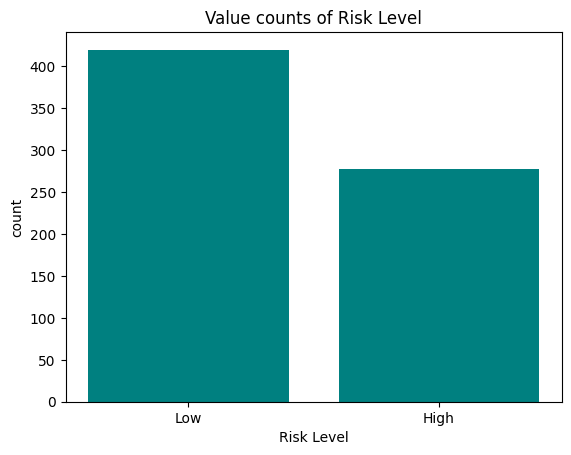

In [15]:
# show values counts for target variable
value_counts = y_train.value_counts()
print(value_counts)

# show in a barplot
plt.bar(value_counts.index, value_counts.values, color="teal")
plt.title("Value counts of Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("count")
plt.show()

* From the bar plot above, it can be noticed that there is an imbalance of class, as people with low-risk pregnancies are more than those with high-risk pregnancies

In [16]:
# Check for categorical columns. A categorical column must only have 5 or less values 
# and they must not include Risk level
cat_cols = [col for col in X_train.columns if X_train[col].nunique() <= 5]
cat_cols

['Previous Complications',
 'Preexisting Diabetes',
 'Gestational Diabetes',
 'Mental Health']

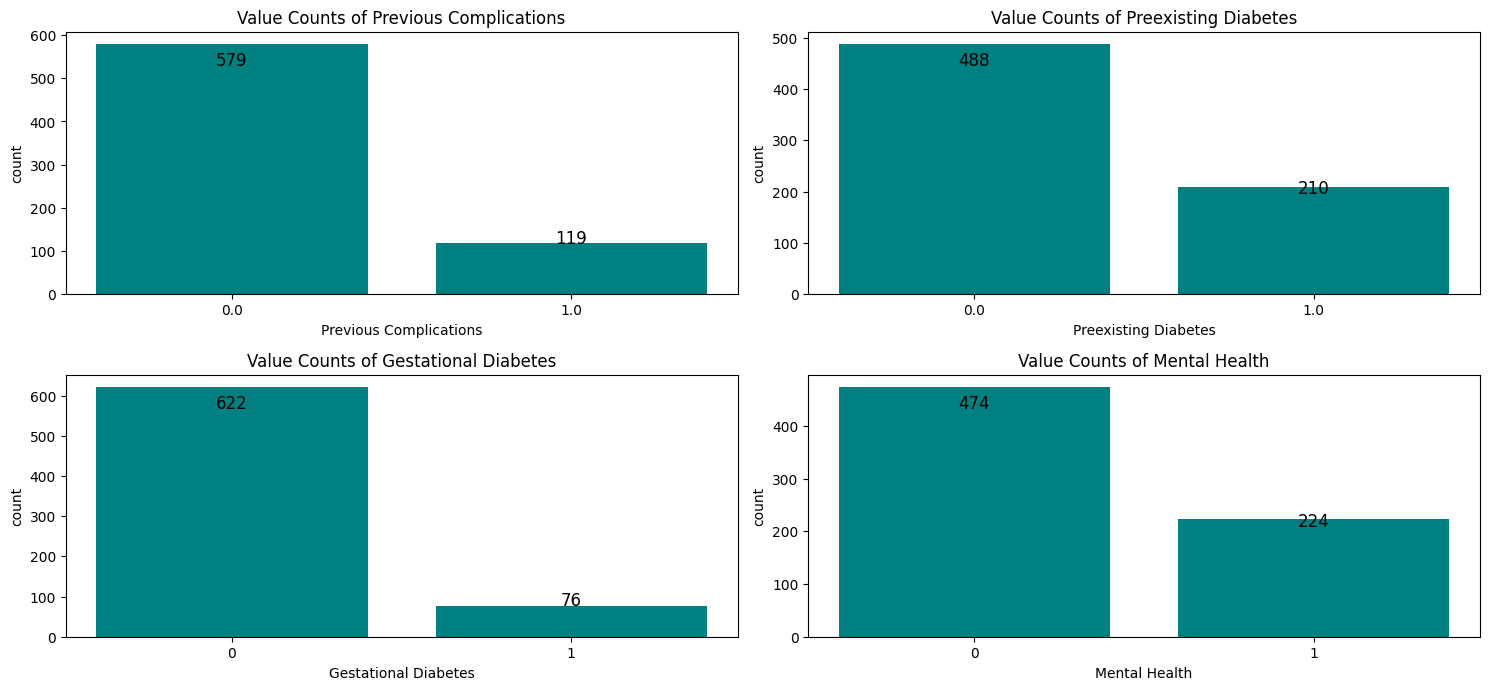

In [17]:
# check for the value count in each categorical column
plt.figure(figsize=(15,10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    value_counts = X_train[col].value_counts()
    bars = plt.bar(value_counts.index.astype(str), value_counts.values, color="teal")
    plt.title(f"Value Counts of {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("count")
    plt.tight_layout()

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height-0.1*height, f"{int(height)}",
                 ha="center", va="bottom", fontsize=12)

plt.show()

* 0 means 'No' and 1 means 'Yes'
* Just like the target column (Risk Level), those with none of the conditions above are more than those recorded to be with it

In [18]:
# select the numeric columns, those that are not in the list of categorical columns
# and not Risk level
num_cols = [col for col in X_train.columns if col not in cat_cols]
num_cols

['Age', 'Systolic BP', 'Diastolic', 'BS', 'Body Temp', 'BMI', 'Heart Rate']

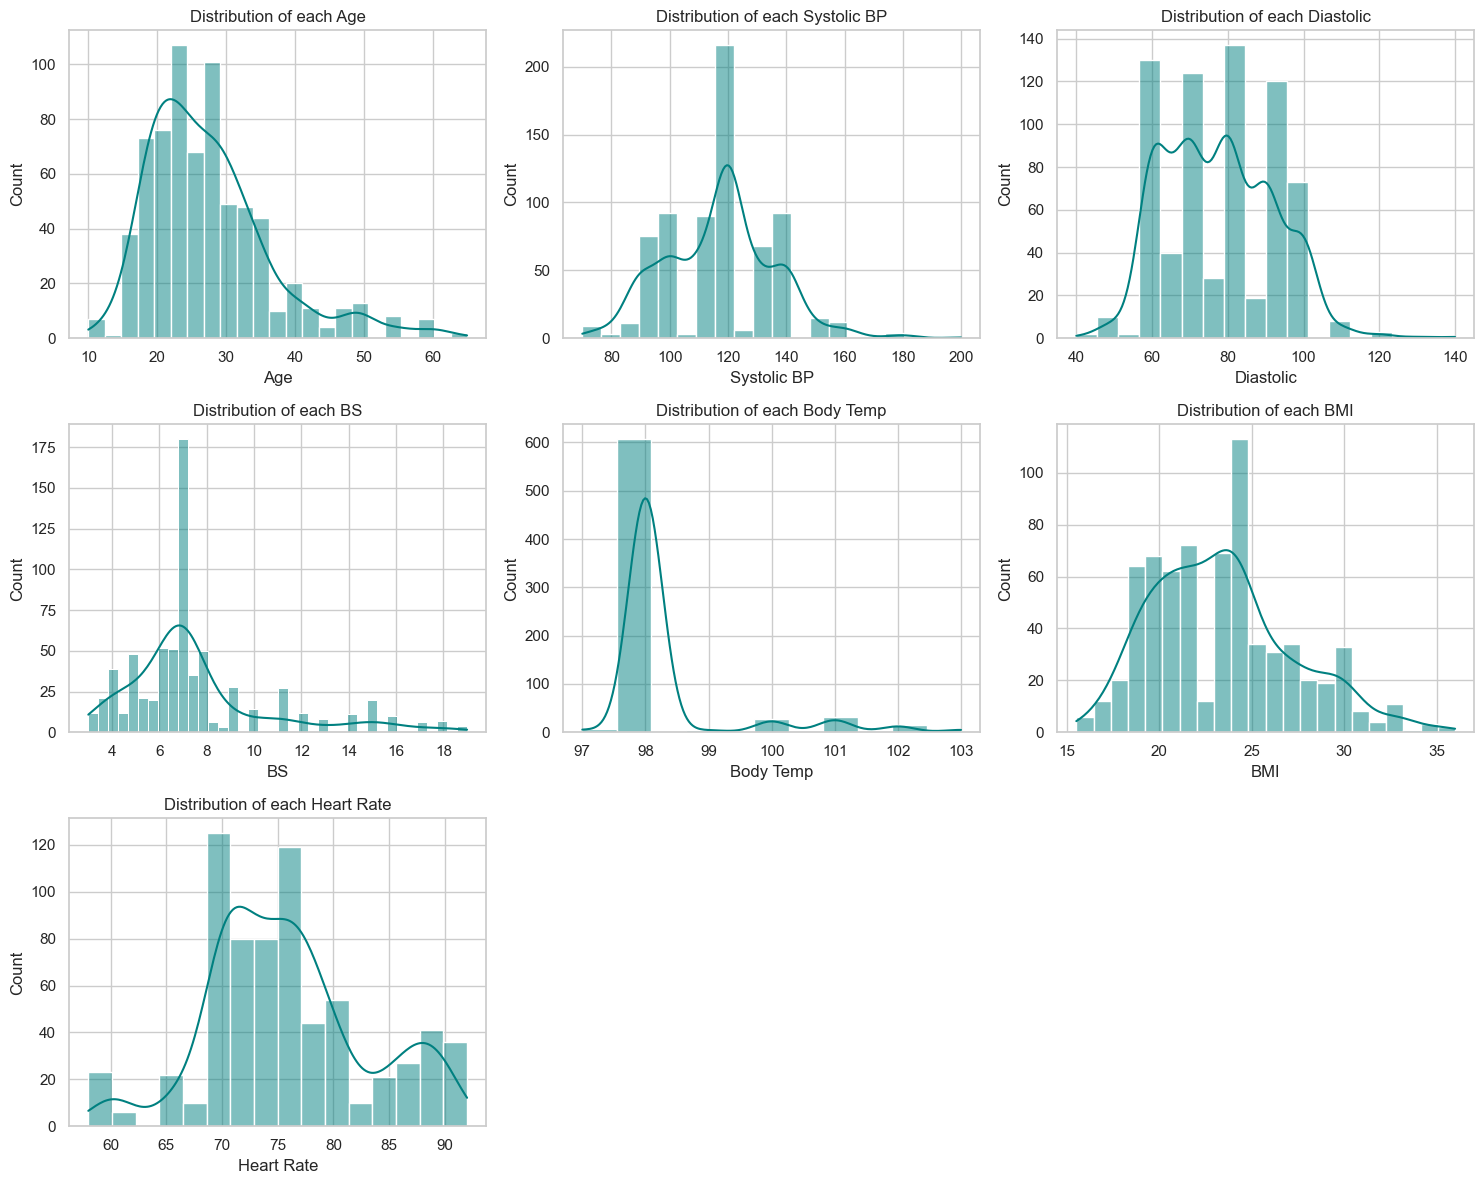

In [19]:
# check distribution of the numerical values
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 12))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=X_train, x=col, kde=True, color="teal")
    plt.title(f"Distribution of each {col}")
    plt.xlabel(col)
    plt.tight_layout()

plt.show()

* The KDE line helps to show the shape of the data
* Age is mildly skewed to the right and shows that most patients recorded are between the age of 20 to 30
* BS is so skewed to the right showing that some patients have extremely high blood sugar levels, but most patients are within normal ranges of blood sugar levels for pregnant women
* BMI, although almost taking the shape of a normal distribution, is still skewed to the right showing pregnant women with high BMIs, but most are still within the normal leves of 18.5 to 24.9
* Most patients show a normal body temperature at 98F but some have temperature of higher than 100F
* Heart Rate shows that most patients here have their heart rate between the normal levels of 60 to 90 beats per minutes at rest
* There is a variation in the systolic and diastolic blood pressure with some patients having extremely high or low blood pressure levels

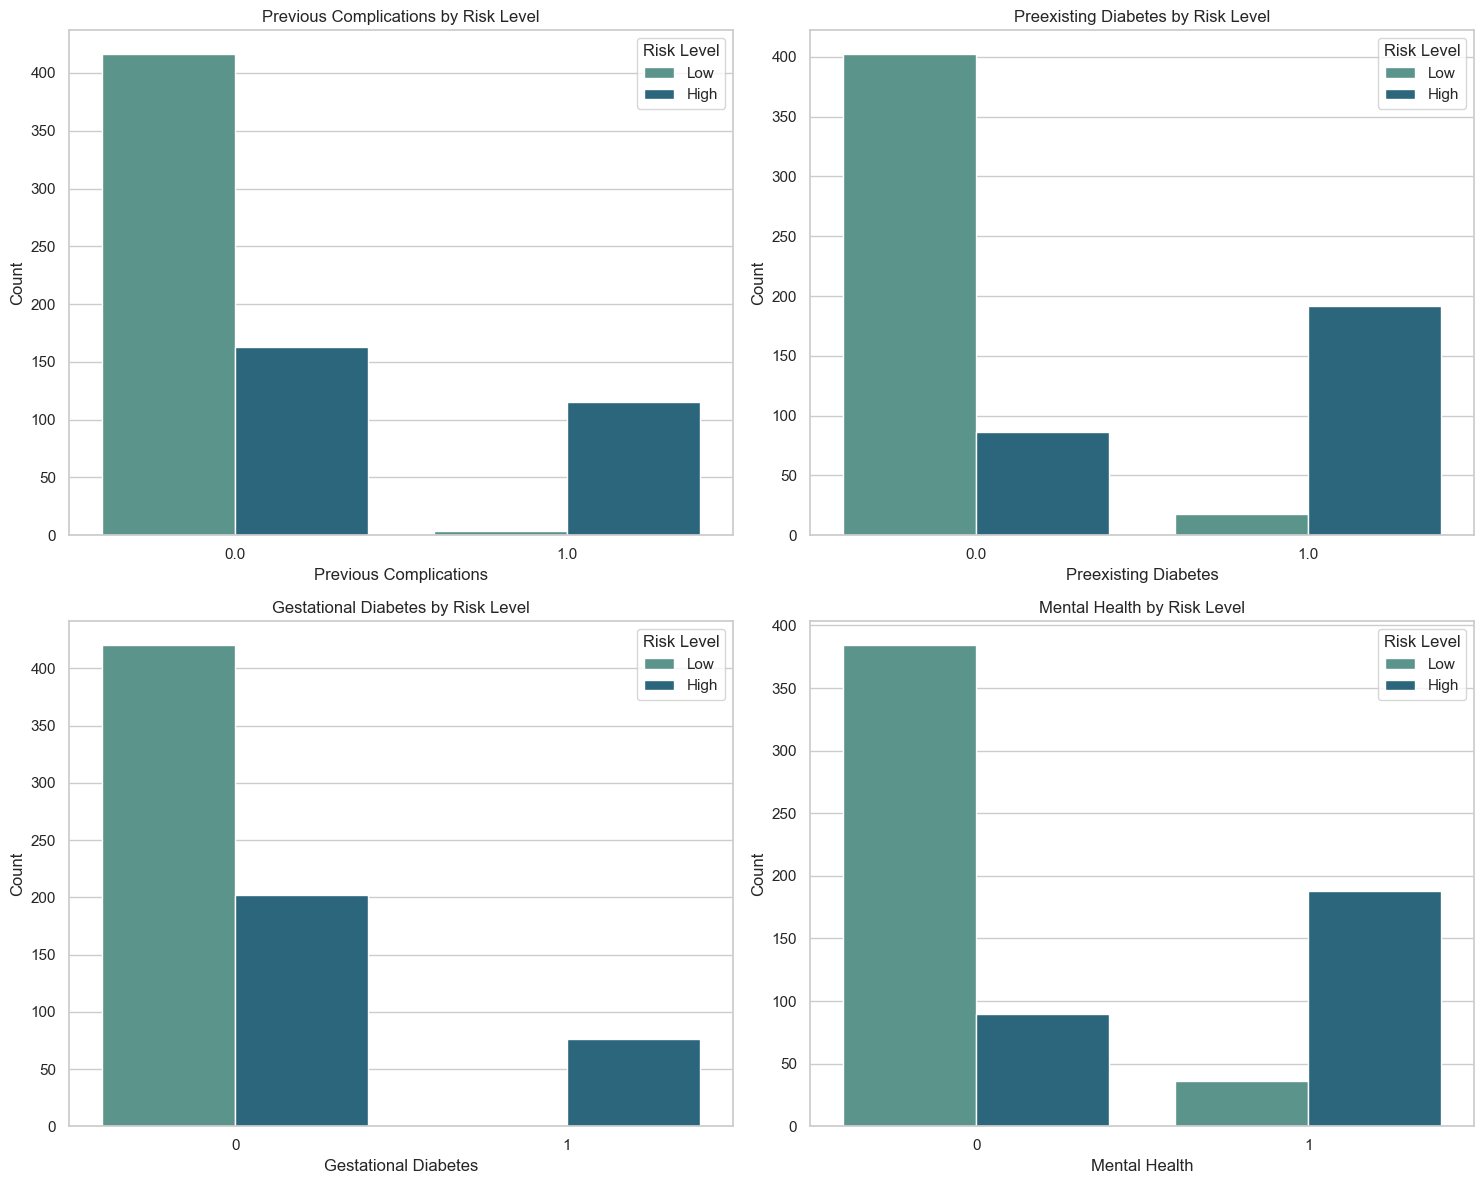

In [20]:
# compare the categorical columns to the target column

plt.figure(figsize=(15, 12))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=X_train, x=col, hue=y_train, hue_order=["Low", "High"] ,palette="crest")
    plt.title(f"{col} by Risk Level")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.legend(title="Risk Level")
    plt.tight_layout()
plt.show()

* **Previous Complications**: More high-risk cases occur among those with no previous complications
* **Preexisting Diabetes**: More high-risk cases occur among those with preexisting diabetes, showing a strong association
* **Gestational Diabetes**: Same as the situation with previous complications. I'm thinking this might be because gestational diabetes isn't diagnosed until after 20 weeks of pregnancy
* **Mental Health**: Also shows that most people with mental health issues are clasified as High-risk cases.

* Use chi-square to check for significance of each of these columns to the target column.

In [21]:
# use chi-square test to check for statistical significance of the categorical columns to the target variable
# H0 - There is no significant relationship between each feature and the target variable
for col in cat_cols:
    contingency_table = pd.crosstab(X_train[col], y_train)
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-Square Test for '{col}' vs 'Risk Level':")
    print(f"Chi2 = {chi2: .2f}, p-value = {p:.55f}, Degree of freedom = {dof}")
    if p < 0.05:
        print("=> Significant relationship (reject H0)")
    else:
        print("=> No significant relationship (fail to reject H0)")
    print("-" * 50)

Chi-Square Test for 'Previous Complications' vs 'Risk Level':
Chi2 =  190.35, p-value = 0.0000000000000000000000000000000000000000002667534853851, Degree of freedom = 1
=> Significant relationship (reject H0)
--------------------------------------------------
Chi-Square Test for 'Preexisting Diabetes' vs 'Risk Level':
Chi2 =  330.65, p-value = 0.0000000000000000000000000000000000000000000000000000000, Degree of freedom = 1
=> Significant relationship (reject H0)
--------------------------------------------------
Chi-Square Test for 'Gestational Diabetes' vs 'Risk Level':
Chi2 =  126.05, p-value = 0.0000000000000000000000000000300219675815757643116756612, Degree of freedom = 1
=> Significant relationship (reject H0)
--------------------------------------------------
Chi-Square Test for 'Mental Health' vs 'Risk Level':
Chi2 =  264.98, p-value = 0.0000000000000000000000000000000000000000000000000000000, Degree of freedom = 1
=> Significant relationship (reject H0)
------------------------

Risk Level         High         Low
Age           30.140288   25.738095
Systolic BP  124.730216  112.014286
Diastolic     84.374101   73.016667
BS             9.879496    6.039571
Body Temp     98.589928   98.176190
BMI           25.980216   21.651429
Heart Rate    80.294964   72.866667


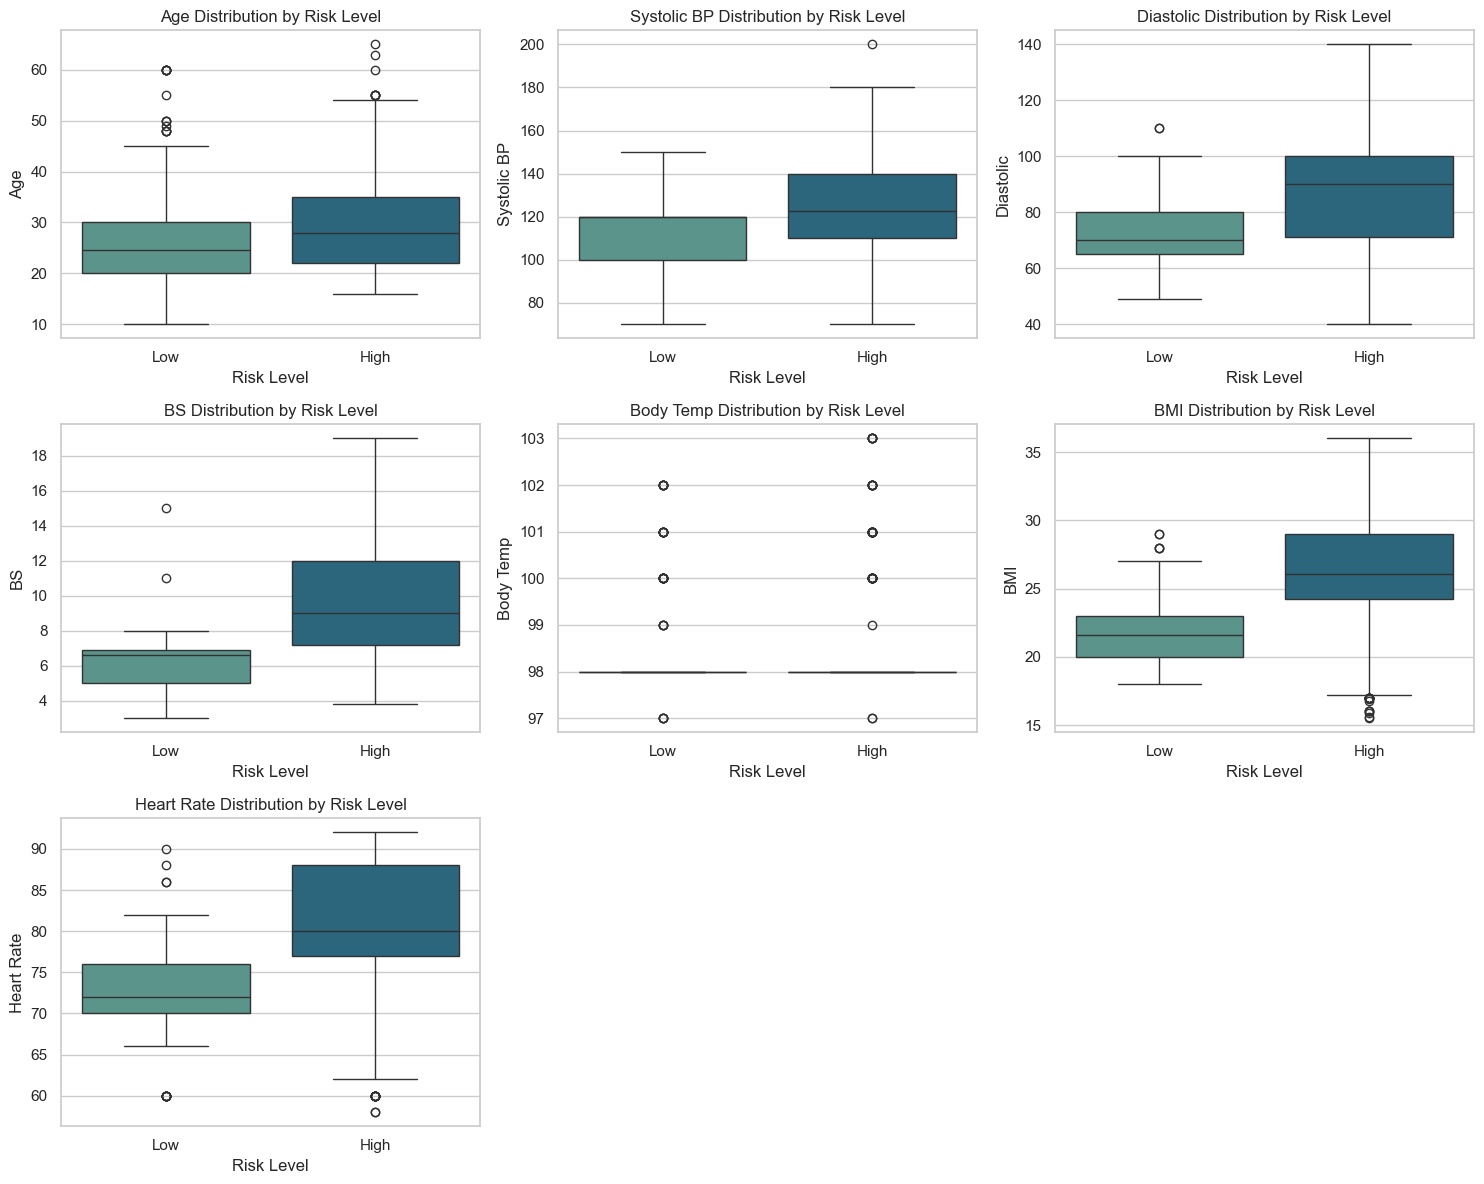

In [22]:
# let's compare the numerical columns with the risk level

# compute their mean for each risk level
print(X_train.groupby(y_train)[num_cols].mean().T)

# plot a boxplot
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=X_train, x=y_train, y=col, palette="crest")
    plt.title(f"{col} Distribution by Risk Level")
    plt.tight_layout()
plt.show()

* The first result shows mean values between each class of the risk values. From the result, there seems to be not much difference between the mean values for each class, so we'll test for a statistical significance later
* The boxplots seem to show outliers, which will not be removed. Because, although they are extreme values, they are valid.
* Each variable shows higher values or lower for high risk pregnancies
* While a high body temperature can be a sign of an underlying infection, it's also normal for pregnant women to experience an increase in body temperature. Based on the chart, 98F is the normal for both risk levels.

In [23]:
# split data into two groups
low_risk = X_train[y_train == "Low"]
high_risk = X_train[y_train == "High"]
# perform T-test for each numerical variable
for col in num_cols:
    stat, p = ttest_ind(low_risk[col], high_risk[col], equal_var=False)
    print(f"{col}: T-statistic = {stat:.4f}, p-value = {p:.50f}")
    if p < 0.05:
        print("=> Significant relationship (reject H0)")
    else:
        print("=> No significant relationship (fail to reject H0)")
    print("-" * 50)

Age: T-statistic = -6.1856, p-value = 0.00000000126333201662059778147942174441557133812708
=> Significant relationship (reject H0)
--------------------------------------------------
Systolic BP: T-statistic = -8.6795, p-value = 0.00000000000000007498843060888317558715117060428058
=> Significant relationship (reject H0)
--------------------------------------------------
Diastolic: T-statistic = -10.3498, p-value = 0.00000000000000000000009927186161926191701396650993
=> Significant relationship (reject H0)
--------------------------------------------------
BS: T-statistic = -16.7471, p-value = 0.00000000000000000000000000000000000000000000062868
=> Significant relationship (reject H0)
--------------------------------------------------
Body Temp: T-statistic = -4.8655, p-value = 0.00000165152465771820618434468155855121551667252788
=> Significant relationship (reject H0)
--------------------------------------------------
BMI: T-statistic = -15.5355, p-value = 0.0000000000000000000000000000

<Axes: >

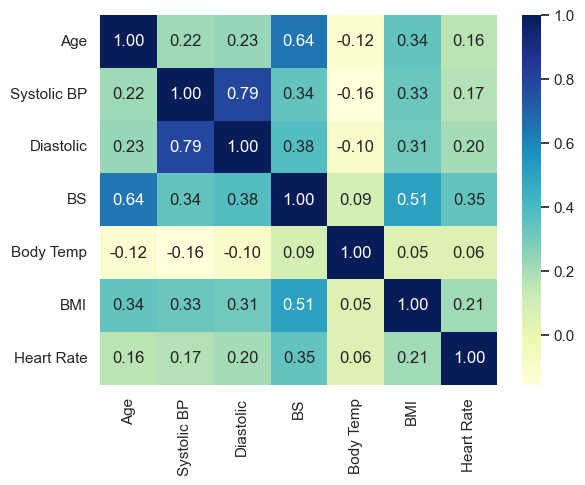

In [24]:
# check for correlation between the numerical variables
corr = X_train[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu")

From the heatmap above, it can be seen that
* Age and BS have a moderate correlation of o.60
* Age and BMI also have a moderate correlation of 0.34
* Systolic BP and Diastolic have a strong correlation, as expected, and this can cause multicollinearity
* Systolic BP and Diastolic have a correlation of 0.34 and 0.35 with BS, respectively.
* BS and BMI have a moderate correlation of 0.50, which can be said to show how overweogt people might have issues with their blood sugar levels

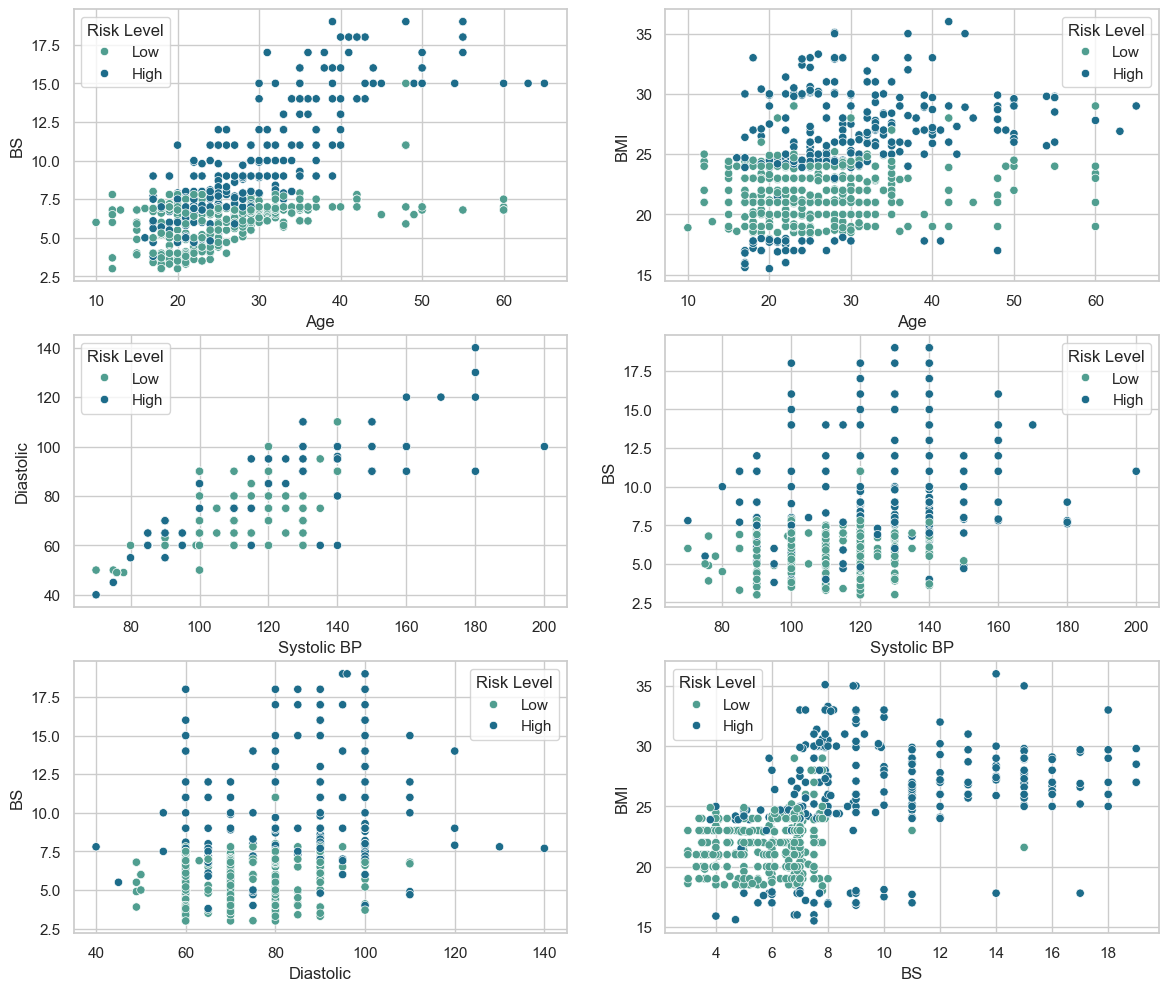

In [25]:
# plot scatterplots for those features where significant correlations were noticed
num_pairs = [
    ("Age", "BS"), 
    ("Age", "BMI"),
    ("Systolic BP", "Diastolic"),
    ("Systolic BP", "BS"),
    ("Diastolic", "BS"),
    ("BS", "BMI")]

plt.figure(figsize=(14, 12))
for i, (col1, col2) in enumerate(num_pairs, 1):
    plt.subplot(3, 2 , i)
    sns.scatterplot(data=X_train, x=col1, y=col2, hue=y_train, palette="crest")

plt.show()

From the scatter plot above, where I explored the relationship between different pairs that have moderate or correlation, it can be seen that:

* There is a positive association between BS and Age for High-risk cases, meaning Older pregnant women with higher blood sugar are more likely to be high risk. Low-risk cases can be seen to be clustered around BS levels less than 10 and Age less than 40

* Low-risk cases are clustered around 18-23 and Age below 40. High risk cases are more spread out around lower BMI (<18) and higher BMI (>23)

* Diastolic and Systolic BP show a very high correlation, as seen before. It also shows that low risk cases are more common when systolic BP is < 140 and diastollic < 100

* There isn't a stron correlation between BS and Systolic BP or diastolic BP, but low-risk cases tend to cluster where BS < 10, systolic BP < 140 and diastolic < 100

* There is a bit of noticeable trend in High-risk cases as BMI and BS increases. Low-level risks are clustered at BMI < 30 and BS < 8.

### Preprocessing

### Check for Multicollinearity

* Multicollinearity is when two or more independent variables are highly correlated with each other. It's more like two or more features are saying the same thing and it can confuse the model

* From the correlations done above, we can definitely see that there is quite some moderate correlations between most of the features, but we'll see one with high correlation, i.e., Systolic BP and Diastolic

In [27]:
X_train["BP Ratio"] = X_train["Systolic BP"] / X_train["Diastolic"]
X_train.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Mental Health,Heart Rate,BP Ratio
980,24,120.0,80.0,6.6,98,19.9,0.0,0.0,0,74.0,1.500000
279,22,120.0,85.0,4.1,98,23.9,0.0,0.0,0,74.0,1.411765
783,18,120.0,80.0,6.8,102,24.4,0.0,0.0,1,76.0,1.500000
607,17,90.0,60.0,6.9,98,22.0,0.0,0.0,0,76.0,1.500000
659,18,90.0,60.0,6.9,98,19.0,0.0,0.0,0,70.0,1.500000


In [28]:
low_risk = X_train[y_train == "Low"]["BP Ratio"]
high_risk = X_train[y_train == "High"]["BP Ratio"]

stat, p = ttest_ind(low_risk, high_risk)
print(f"BP Ratio: T-statistic = {stat:.4f}, p-value = {p:.50f}")
if p < 0.05:
    print("=> Significant relationship (reject H0)")
else:
    print("=> No significant relationship (fail to reject H0)")

BP Ratio: T-statistic = 4.1180, p-value = 0.00004280488643477724382789550983119397642440162599
=> Significant relationship (reject H0)


Risk Level
High    1.492479
Low     1.549082
Name: BP Ratio, dtype: float64


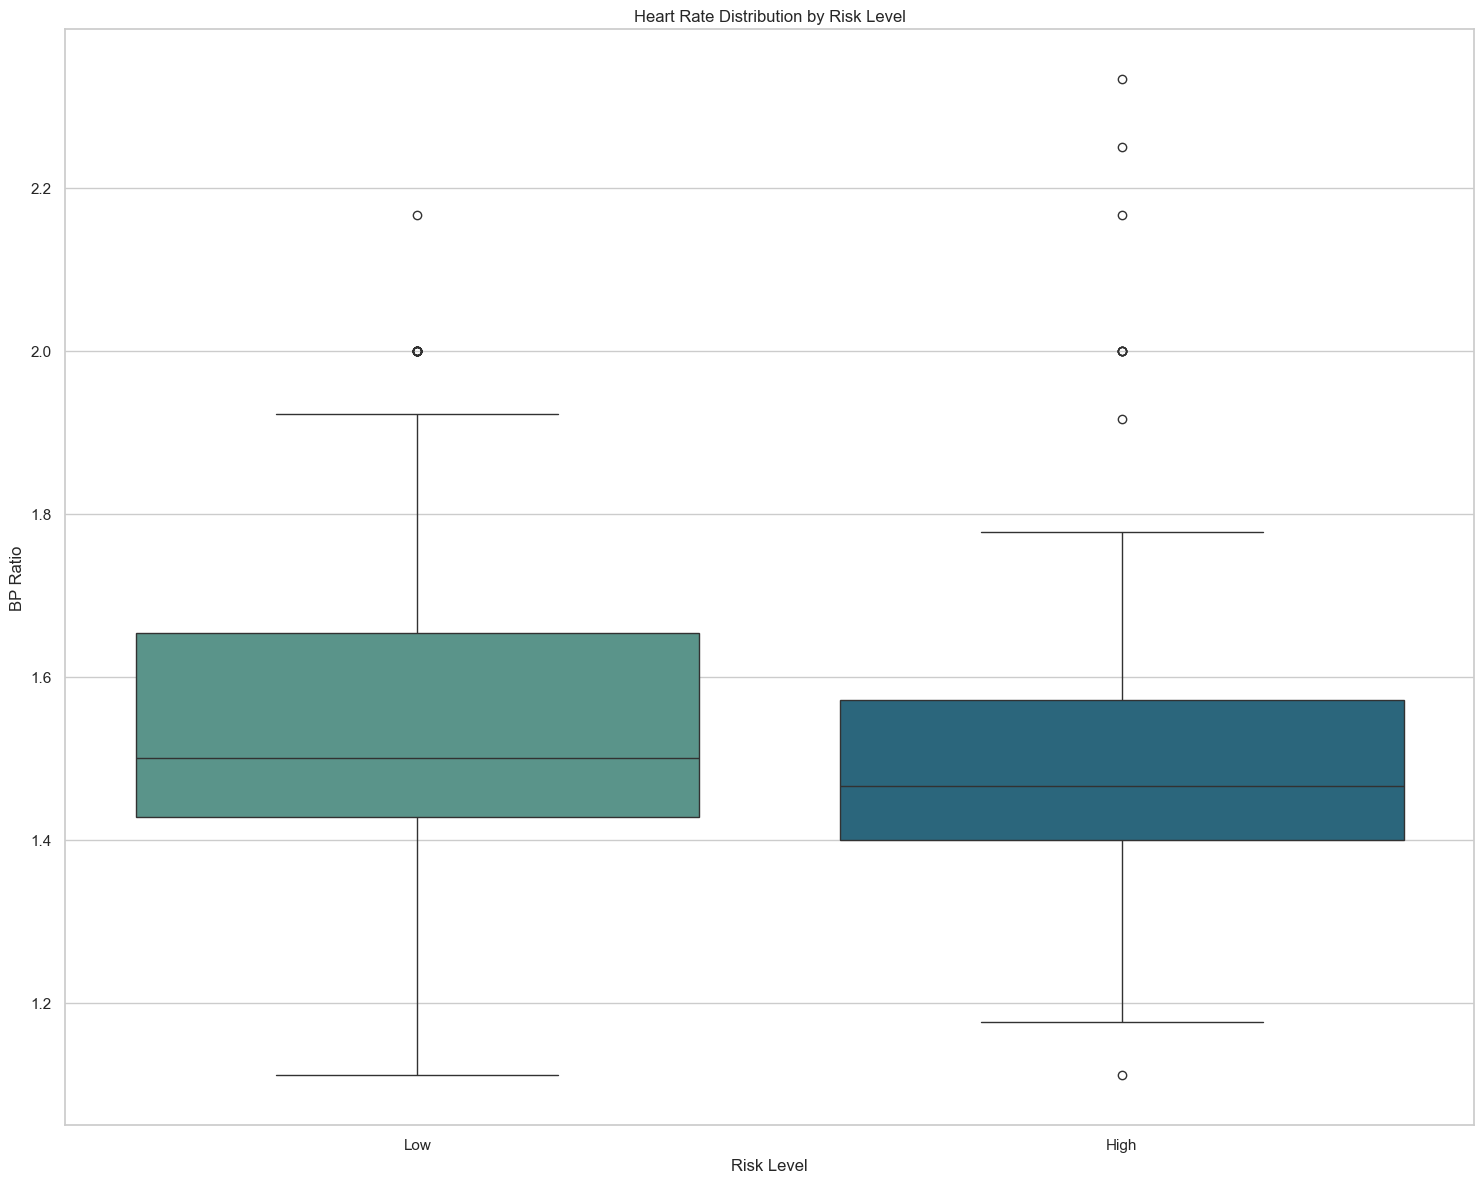

In [29]:
# compute their mean for each risk level
print(X_train.groupby(y_train)["BP Ratio"].mean().T)

# plot a boxplot
plt.figure(figsize=(15, 12))
sns.boxplot(data=X_train, x=y_train, y="BP Ratio", palette="crest")
plt.title(f"{col} Distribution by Risk Level")
plt.tight_layout()
plt.show()

In [30]:
maternal=X_train.copy()

### Remove Leakages

* Data Leakages can occur when a model sees data it shouldn't have access to at the time of prediction, cusing overfitting. It's like having answers to an exam before the exam.

* In this case, because we're trying to predict pregnancy being a risk in its early stage, gestional diabetes column was classified a leaky column since it's normally noticed only after 20 weeks of pregnancy.

In [ ]:
# remove leaky columns
maternal = maternal.drop(columns=["Gestational Diabetes"])
maternal.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Mental Health,Heart Rate
980,24,120.0,80.0,6.6,98,19.9,0.0,0.0,0,74.0
279,22,120.0,85.0,4.1,98,23.9,0.0,0.0,0,74.0
783,18,120.0,80.0,6.8,102,24.4,0.0,0.0,1,76.0
607,17,90.0,60.0,6.9,98,22.0,0.0,0.0,0,76.0
659,18,90.0,60.0,6.9,98,19.0,0.0,0.0,0,70.0


In [31]:
# use robust scaler to scale all numerical columns
scaler = RobustScaler()

maternal[num_cols] = scaler.fit_transform(maternal[num_cols])

In [32]:
# drop some columns which are not essential
maternal = maternal.drop(columns=["Systolic BP", "Diastolic", "Body Temp"])

In [33]:
y_train.tail(10)

495     High
1067    High
290      Low
670      Low
476      Low
281      Low
29      High
467      Low
182     High
297      Low
Name: Risk Level, dtype: object

In [34]:
# Instantiate the Label encoder and train on y_train
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train_encoded[-10:]

# use this to transform the test and validation_set
y_test_encoded = le.transform(y_test)
y_val_encoded = le.transform(y_val)


In [35]:
le.classes_

array(['High', 'Low'], dtype=object)

In [36]:
maternal.head()

,Age,BS,BMI,Previous Complications,Preexisting Diabetes,Mental Health,Heart Rate,BP Ratio
980,-0.090909,-0.157895,-0.725146,0.0,0.0,0,-0.2,1.500000
279,-0.272727,-1.473684,0.210526,0.0,0.0,0,-0.2,1.411765
783,-0.636364,-0.052632,0.327485,0.0,0.0,1,0.0,1.500000
607,-0.727273,0.000000,-0.233918,0.0,0.0,0,0.0,1.500000
659,-0.636364,0.000000,-0.935673,0.0,0.0,0,-0.6,1.500000


In [37]:
# Train a Dummy Classifier as the baseline model

# Create the dummy classifier
dummy_model = DummyClassifier(strategy="most_frequent")
# Train on training data
dummy_model.fit(maternal, y_train_encoded)
# Predict
y_pred_dummy = dummy_model.predict(maternal)
# Evaluate
print(classification_report(y_train_encoded, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       278
           1       0.60      1.00      0.75       420

    accuracy                           0.60       698
   macro avg       0.30      0.50      0.38       698
weighted avg       0.36      0.60      0.45       698



### Transformers

In [38]:
# Build Custom Transformer to calculate the BP Ratio and add as a column
class BPRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X["BP Ratio"] = X["Systolic BP"] / X["Diastolic"]
        return X
    

In [47]:
# Custom transformer to drop some columns

class DropSomeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.drop(columns=self.columns_to_drop, errors="ignore")
        else:
            raise TypeError("Input should be a Pandas DataFrame")


In [66]:
# create column transformer to exclude the categorical columns while scaling the others

# redefine num_cols
final_num_cols = [col for col in num_cols if col not in ['Systolic BP', 'Diastolic', 'Body Temp']]
scaler = ColumnTransformer(transformers=[('scaler', RobustScaler(), final_num_cols)],
                                 remainder="passthrough")

# create list of columns to drop
columns_to_drop = ["Systolic BP", "Diastolic", "Body Temp", "Gestational Diabetes"]

In [67]:
# Build my Pipeline

pipeline = Pipeline(steps=[
    ('attr_adder', BPRatio()),
    ('column_dropper', DropSomeFeatures(columns_to_drop=columns_to_drop)),
    #('scaler', scaler),
    ('logistic_regression', LogisticRegression(class_weight='balanced'))
])

In [68]:
# Train the model and evaluate
pipeline.fit(X_train, y_train_encoded)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate
print(classification_report(y_val_encoded, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        High       0.42      0.42      0.42        93
         Low       0.62      0.62      0.62       140

    accuracy                           0.54       233
   macro avg       0.52      0.52      0.52       233
weighted avg       0.54      0.54      0.54       233

